In [ ]:
from keras.preprocessing import text
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import skipgrams
from keras.layers import dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input
from keras.utils import plot_model
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# using gpu
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

#### Report:
Packages are imported and GPU is enabled!

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Text Preprocessing

In [ ]:
with open('drive/My Drive/Colab Notebooks/Problem1_HW4/ferdosi.txt', 'r') as file:
  whole_text = file.read()

whole_text = whole_text.split('\n')[:-1]
sentences = []

for line in whole_text:
  parts = line.split(',')
  first_part = parts[0].rstrip()
  second_part = parts[1][1:]
  sentences = sentences + [first_part + ' ' + second_part]

#### Report:
The whole text of 'Shahname' is readed and splitted to lines. After that, first part and second part(by part I mean 'Mesra') are separated and extra space characters at the end of first part and at the begining of second part are removed. After that, these two parts are concatenated to form 'sentences' which contains our sentences for skip-gram model.

### Building Vocabulary

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(sentences)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 25

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in sentences]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[10:20])

Vocabulary Size: 17659
Vocabulary Sample: [('گفت', 11), ('شد', 12), ('شاه', 13), ('تو', 14), ('بود', 15), ('او', 16), ('یکی', 17), ('همه', 18), ('ان', 19), ('اندر', 20)]


#### Report:
We generate our vocabulary in this part. As you can see, There are 17659 different words(17658 actually) and 10 samples of this dictionary are represented.

### Skip-gram Generator

In [ ]:
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=2) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(کزین (364), بدروزگار (7885)) -> 0
(خرد (98), پیش (29)) -> 0
(کزین (364), نیارمت (9475)) -> 0
(نام (81), مکر (6467)) -> 0
(برنگذرد (3535), دمد (11996)) -> 0
(خرد (98), و (1)) -> 1
(به (2), نام (81)) -> 1
(خرد (98), برتر (698)) -> 1
(برتر (698), بیسچ (13755)) -> 0
(برتر (698), کیمال (8474)) -> 0


#### Report:
by using 'skipgrams' method with 'window_size' equal to 2(Capturing 5 consecutive words), we prepare our dataset. We have both negative and positive samples. Negative sample is non-contextual couple of words whose label is zero. And positive sample is contextual couple of words whose label is 1.

### Building The Model





Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 25)        441475      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 25)        441475      input_2[0][0]                    
________________________________________________________________________________________

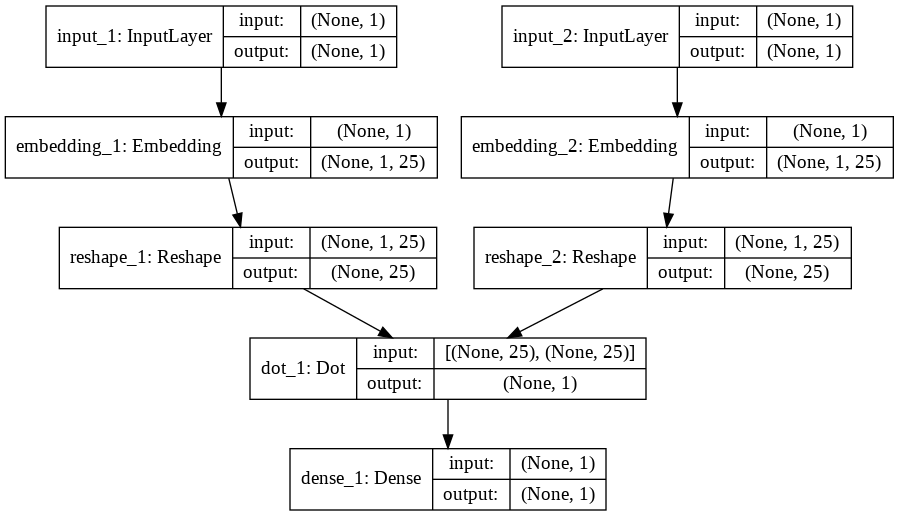

In [ ]:
# input layer
word_input = Input(shape=(1,))

# embedding layer
embedding_layer = Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1)
embedded_word = embedding_layer(word_input)

# reshaping layer
reshaping_layer = Reshape((embed_size, ))
reshaped_word = reshaping_layer(embedded_word)

word_model = Model(word_input, reshaped_word)

# context input layer
context_input = Input(shape=(1,))

# embedding layer
embedding_layer2 = Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1)
embedded_context = embedding_layer2(context_input)

# reshaping layer
reshaping_layer2 = Reshape((embed_size, ))
reshaped_context = reshaping_layer2(embedded_context)

context_model = Model(context_input, reshaped_context)

# Merge
dot_output = dot([reshaped_word, reshaped_context], axes=1, normalize=False)

# dense layer
Dense_Layer = Dense(1, kernel_initializer='glorot_uniform',
                            activation='sigmoid')
model_output = Dense_Layer(dot_output)

model = Model([word_input, context_input], model_output)

model.compile(loss="mean_squared_error", optimizer="rmsprop")

# view model summary
print(model.summary())

# visualize model structure
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

#### Report:
We build our model whose structure is represented above. We use an embedding layer of size 25 for both 'word' and 'context' inputs. And after reshaping these embeddings, we merge them and pass them to Dense layer to decide about the label.

### Training The Model

In [ ]:
for epoch in range(1, 21):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    loss = loss / len(sentences)
    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs




Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Processed 40000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 0.12299625985206393
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Processed 40000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 0.10332052196837116
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Processed 40000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 0.10073575328036183
Processed 0 (skip_

#### Report:
We train our model for 20 epochs. As you can see above, our 'Loss' is decreasing gradually.

### Saving The Model

In [ ]:
model.save('drive/My Drive/Colab Notebooks/Problem1_HW4/20epoch-mesra') 

### Get Word Embeddings

In [ ]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print('Shape of Embeddings : {0}'.format(weights.shape))
pd.DataFrame(weights, index=id2word.values()).tail()

Shape of Embeddings : (17658, 25)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
غلتم,-0.079591,0.060408,-0.067204,0.063123,0.077072,0.067599,-0.061138,-0.075074,0.078392,0.050426,-0.062588,-0.045208,-0.067905,-0.076474,-0.046463,0.050402,-0.053169,-0.048135,-0.058063,0.061504,-0.077022,0.049418,-0.049528,0.075640,-0.031109
دواج,-0.069180,0.057472,-0.048451,0.054710,0.055712,0.070238,-0.049617,-0.061012,0.065862,0.071719,-0.058046,-0.062878,-0.038578,-0.051319,-0.046067,0.054538,-0.072713,-0.057695,-0.048381,0.048395,-0.063696,0.075999,-0.062962,0.059856,0.000327
مد,-0.071234,0.061227,-0.055785,0.052150,0.048438,0.071731,-0.058044,-0.079435,0.066363,0.056829,-0.059933,-0.058365,-0.013307,-0.074602,-0.065012,0.080534,-0.053668,-0.080220,-0.058463,0.080773,-0.063695,0.072135,-0.044955,0.059612,0.013952
هجرت,-0.069686,0.064801,-0.064760,0.068143,0.046239,0.071709,-0.046485,-0.061133,0.080864,0.073293,-0.064171,-0.066757,-0.066963,-0.067793,-0.067945,0.054885,-0.055116,-0.058360,-0.073965,0.053642,-0.078416,0.067594,-0.067117,0.058377,-0.018517
هشتادبار,-0.070505,0.056941,-0.050438,0.066794,0.076631,0.055110,-0.049555,-0.071408,0.070895,0.072426,-0.051773,-0.067329,-0.039484,-0.049612,-0.079965,0.064358,-0.059716,-0.068590,-0.051019,0.048865,-0.057733,0.057010,-0.069018,0.055936,0.015630


#### Report:
We extract our embedding weights for our target words. The shape of embeddings and 5 last embedding weights are represented.

### Cosine Distance

In [ ]:
distance_matrix = cosine_distances(weights)
print('Shape of Cosine Distances: {0}'.format(distance_matrix.shape))

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['گلاب', 'سیستان', 'ایران', 'رستم', 'خردمند']}

pd.DataFrame(similar_words)

Shape of Cosine Distances: (17658, 17658)


,گلاب,سیستان,ایران,رستم,خردمند
0,چمان,دارا,کین,بماند,باید
1,ومهان,شدشان,نزد,بخت,گوی
2,کلک,رنجتان,پدر,برد,بپرسید
3,ندانیم,تندباد,برین,دارد,گو
4,فرب,هماون,خرد,بار,اختر


#### Report:
We compute cosine distance between the embeddings and find the 5 most similar words to the words that were asked. You can see these words in a table above. As we can see, the results are satisfactory and their are some meaningful relations between the words.

### T-SNE Visualization

Total words: 30 	Word Embedding shapes: (30, 25)


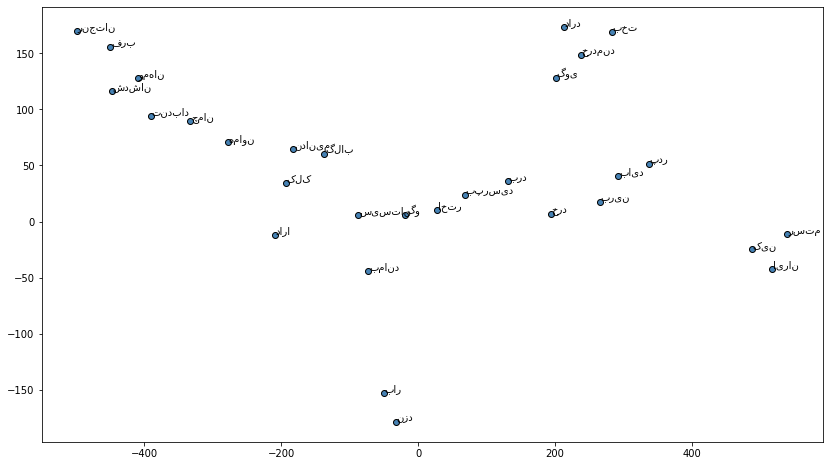

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Report:
At last, we use T-SNE visualization to show the small distance between the asked words and their 5 most contextual-coupled words.